# L'algorithme RANSAC (RANdom SAmple Consensus)

## 1. Ransac : Un algorithme robuste aux outliers

### Un exemple simple

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


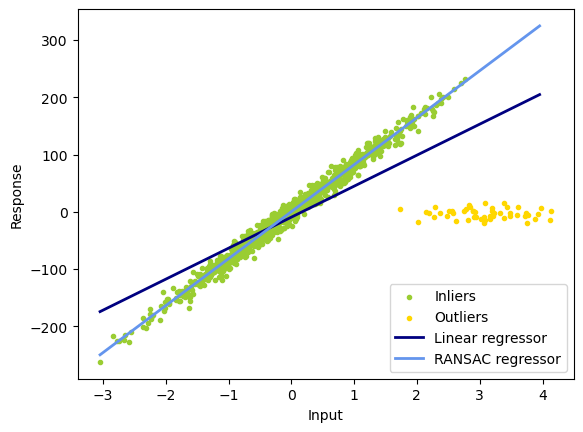

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model

n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=0,
)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

## 2. Qu'est ce que RANSAC ?

RANSAC est un algorithme itératif pour estimer un modèle mathématique à partir d'un ensemble de données qui contient des valeurs aberrantes. Il est très utile pour les problèmes de régression linéaire où les données sont polluées par des valeurs aberrantes.
- Utilisé notamment pour la computer vision, le traitement d'images ou les ondes sonores.  

### Le Principe

RANSAC sélectionne uniformément et au hasard un sous-ensemble d'échantillons de données et l'utilise pour estimer les bons paramètres du model. Il détermine les échantillons qui se situent dans une tolérance d'erreur de la valeur du model généré. 
- Ces échantillons sont considérés comme étant en accord avec le modèle généré et appelés ainsi **ensemble consensuel** des échantillons de données choisis. Ici, les échantillons consensuels se comportent comme des inliers et le reste sont considérés comme valeurs aberrantes par RANSAC.
- Si le nombre d’échantillons consensuels est assez élevé il entraîne alors le modèle final sur ces données. Il répète ce processus pendant un nombre _k_ d'itérations et renvoie le modèle qui présente la plus petite erreur moyenne parmi les modèles générés.

En tant qu'algorithme randomisé, RANSAC ne garantit pas de trouver le modèle paramétrique optimal par rapport aux inliers. Mais la probabilité d’atteindre la solution optimale peut être maintenue à un niveau minimum de performance en attribuant des valeurs appropriées aux paramètres de l'algorithme.

Conseillé d'utiliser davantage d'échantillons de données que le sous-ensemble minimal par défauts requis (Au moins 2 sous-ensembles dans le cas d'un model linéaire, 3 sous-ensembles dans le cas d'un model circulaire par exemples) car une estimation plus précise du modèle peut être obtenue. 
- Plus d'échantillons augmentent la probabilité de trouver le modèle optimal. Mais cela augmente également le temps de calcul pour la sélection du sous-ensemble.
- Le nombre d'itérations _k_ est un paramètre important de l'algorithme. Il détermine le nombre de fois que l'algorithme doit être répété pour trouver le modèle optimal. 

## 3. Explications mathématiques

### 3.1. Problème posé

Supposons que nous avons un ensemble de données _D_ et que nous souhaitons ajuster un modèle paramétrique _M_ (par exemple, une droite, un plan, ou un modèle de transformation) à ces données. Les données _D_ contiennent un mélange de points qui suivent le modèle et de points aberrants (outliers).

### 3.2. Définition du modèle

Le modèle _M_ est défini par un ensemble de paramètres _θ_. Par exemple, pour une droite en 2D, les paramètres peuvent être la pente et l'ordonnée à l'origine.

### 3.3. L'algorithme RANSAC

L'algorithme RANSAC suit les étapes suivantes :  

Étape 1 : Initialisation
- Choisissez les paramètres :
  - _k_ : nombre maximum d'itérations.
  - _t_ : seuil de tolérance pour déterminer si un point est un inlier ou un outlier.
  - _d_ : nombre minimal d'inliers requis pour accepter un modèle.  
    
Étape 2 : Itérations
Pour chaque itération (de 1 à _k_) :
- Échantillonnage aléatoire :
    - Sélectionnez aléatoirement un sous-ensemble de _n_ points de données. _n_ est le nombre minimal de points requis pour estimer les paramètres du modèle. Par exemple, pour une droite en 2D, _n_ = 2 points sont nécessaires.
- Modèle hypothétique :
    - Utilisez les _n_ points sélectionnés pour estimer les paramètres _θ_ du modèle hypothétique _M_. Par exemple, pour une droite en 2D, les paramètres _θ_ peuvent être la pente et l'ordonnée à l'origine de la droite.
- Détermination des inliers :
    - Appliquez le modèle hypothétique _M_ à tous les points de données dans _D_.
    - Comptez le nombre de points dans _D_ qui sont à une distance inférieure à _t_ du modèle hypothétique (ces points sont appelés inliers).
- Vérification du modèle :
    - Si le nombre d'inliers est supérieur à _d_, acceptez ce modèle et estimez ses paramètres en utilisant tous les inliers.

Étape 3 : Choix du meilleur modèle

- Après _k_ itérations, choisissez le modèle qui a le plus grand nombre d'inliers. Ce modèle est considéré comme le meilleur modèle pour les données _D_.

### 3.4. Mathématiques

Modèle linéaire en 2D (droite) : y = mx + c
- _θ_ = (m, c) : paramètres du modèle.
- _D_ = {(x1, y1), (x2, y2), ..., (xn, yn)} : ensemble de données.
- Estimation des paramètres : à partir de deux points (x1, y1) et (x2, y2), on a m = (y2 - y1) / (x2 - x1), c = y1 - mx1
_(ces deux formules proviennent de la définition de la pente et de l'ordonnée à l'origine d'une droite)_
- Distance entre un point (x, y) et la droite : d = |y - (mx + c)| / sqrt(1 + m^2)
_(cette formule provient de la définition de la distance entre un point et une droite)_
- Inlier si d < _t_, outlier sinon.

Erreur de modélisation :
- Pour chaque point (xi, yi), l'erreur de modélisation est définie comme l'erreur absolue entre le point et le modèle : e = |yi - (mxi + c)|.
- Si erreur_i < _t_, le point est considéré comme un inlier, sinon c'est un outlier.

Vérification du modèle :
- Si le nombre d'inliers est supérieur à _d_, acceptez ce modèle et estimez ses paramètres en utilisant tous les inliers.
- On peut réajuster la droite en utilisant tous les inliers (pour obtenir une meilleure estimation des paramètres m et c), on peut utiliser une méthode de moindres carrés. min Σ(yi - (mxi + c))^2

Choix du meilleur modèle :
- Après _k_ itérations, choisissez le modèle qui a le plus grand nombre d'inliers. Ce modèle est considéré comme le meilleur modèle pour les données _D_.
- On peut également calculer la moyenne des erreurs de modélisation pour chaque modèle et choisir le modèle avec la plus petite erreur moyenne.

Pourquoi ces calculs ?
- Échantillonnage aléatoire : Il permet de sélectionner différents sous-ensembles de points pour trouver un modèle initialement approximatif. Cela augmente la probabilité de trouver un échantillon sans outliers.
- Calcul du modèle hypothétique : Déterminer les paramètres de la droite à partir de deux points est la base pour estimer la forme de la droite.
- Détermination des inliers : Calculer la distance d'un point à la droite permet de juger si le point suit le modèle (est un inlier) ou non (est un outlier).
- Vérification et ajustement du modèle : En utilisant les inliers pour recalculer les paramètres, on obtient un modèle plus précis et robuste.

## 4. Côté applicatif : Comment utiliser l'algorithme RANSAC depuis la librairie scikit learn ?

### Les paramètres :

In [ ]:
class sklearn.linear_model.RANSACRegressor(estimator=None, *, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None, max_trials=100, max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error', random_state=None)[source]


- <strong>estimator</strong> : object, default = None </br>
    Si None => LinearRegressor() = Estimateur par défaut pour ajuster le modèle aux sous-ensemble de données.
  
- <strong>min_samples</strong> : int (>= 1) or float ([0, 1]), default=None</br>
    Nombre minimum de points de données nécéssaires pour ajuster le modèle
  
- <strong>residual_threshold</strong> : float, default = None</br>
    Le seuil de distance utilisé pour déterminer si un point de données est un inlier. Les points de données dont les résidus sont inférieurs ou égaux à ce seuil sont considérés comme des inliers.
  Par défaut, le seuil est choisi comme la MAD (median absolute deviation = mesure de dispersion statistique pour estimer la variabilité d'un ensemble de données) des valeurs cibles y. Les points dont les résidus sont strictement égaux au seuil sont considérés comme des inliers.
  
- <strong>is_data_valid</strong> :</br>
    Vérifie si un sous-ensemble de données est valide pour l'estimateur. Elle est appliquée à chaque sous-ensemble de données pendant le processus d'ajustement de RANSAC. Si elle n'est pas spécifiée (None par défaut), toutes les données sont considérées comme valides.

- <strong>is_model_valid</strong> :</br>
    Vérifie si un échantillon est valide pour les données d'entrée. Rejeter des échantillons avec cette fonction est plus coûteux en termes de calcul que de le faire avec is_data_valid. Par conséquent, is_model_valid ne doit être utilisée que si le modèle estimé est nécessaire pour prendre la décision de rejet.
  
- <strong>max_trials</strong> : int, default=100</br>
    Le nombre maximum d'itérations pour ajuster et vérifier le modèle.
  
- <strong>max_skips</strong> : int, dafault='np.inf'</br>
    Le nombre maximum d'échantillons tirés qui peuvent être ignorés en raison de sous-ensembles invalides ou de modèles invalides.

- <strong>stop_n_inliers</strong> : int, dafault='np.inf'</br>
    Arrête les itérations si au moins ce nombre d'inliers est trouvé.
  
- <strong>stop_score</strong> :  float, default=np.inf</br>
    Arrête les itérations si le score est supérieur ou égal à ce seuil.

- <strong>stop_probability</strong> : float n range [0, 1], default=0.99</br>
    La procédure itérative de RANSAC s'arrête si au moins un ensemble de données d'entraînement sans valeurs aberrantes est échantillonné par RANSAC. Cela nécessite de générer au moins N échantillons (itérations) :

    N >= log(1 - probability) / log(1 - e**m)

    où la probabilité (confiance) est généralement fixée à une valeur élevée comme 0,99 (la valeur par défaut) et 𝑒 est la fraction actuelle d'inliers par rapport au nombre total d'échantillons.

- <strong>loss</strong> : str, callable, default=’absolute_error’</br>
    Elle doit prendre deux tableaux en entrée (les valeurs vraies et prédites) et renvoyer un tableau 1D avec la perte pour chaque échantillon.
    
- <strong>random_state</strong> : int, RandomState instance ou None, default=None</br>

## 5. Avantages et inconvénients

#### Avantages

- RANSAC est un algorithme robuste qui peut fonctionner même si 50% des données sont des valeurs aberrantes.
- Il est très utile pour les problèmes de régression linéaire où les données sont polluées par des valeurs aberrantes.

#### Inconvénients

- RANSAC est un algorithme randomisé, il ne garantit pas de trouver le modèle paramétrique optimal par rapport aux inliers.
- Le nombre d'itérations _k_ est un paramètre important de l'algorithme. Il détermine le nombre de fois que l'algorithme doit être répété pour trouver le modèle optimal.
- RANSAC est sensible à la sélection des valeurs de seuil. Les valeurs de seuil doivent être définies avec soin pour obtenir des résultats optimaux. (seuil = distance maximale entre un échantillon et le modèle pour être considéré comme inlier)